# Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import ipywidgets as widgets
from fuzzywuzzy import fuzz
%matplotlib inline
from ipywidgets import interactive

# 1. File Loading

## 1.1 Load csv 

In [214]:
tasteData = pd.read_csv('Varietal_taste.csv',encoding='latin-1')
tasteData.head()

Varietal                               Taste
0     Falanghina                 high_tannin, fruity
1     Negroamaro            high_tannin, low_acidity
2  Montepulciano                          chocolatey
3         Grillo            dry, high_tannin, fruity
4       Vermouth  dry, high_tannin, light_body, herb

## 1.2 Load Web Scraped and Web API’s Data

Web scraped data (including varietal, price, region, rating and other features) of all the wine products selling on Wine.com is used to create a wine catalog.

Web scraped data from Total Wine and Web API’s data from Amazon are used to compare the prices of same wine products in the wine catalog.

In [183]:
data=pd.read_csv("WineDotCom.csv",encoding='latin-1').iloc[:,1:]
data.head()
data2=pd.read_csv("TotalWine.csv").iloc[:,1:]
data3=pd.read_csv("AmazonAPI.csv").iloc[:,1:]

## 2.3 Load Text File  

In [129]:
#View description of varietal
all_files = os.listdir("Varietal/") #suppose you are one directory above test dir
print(all_files)
txt_files = filter(lambda x: x[-4:] == '.txt', all_files) #filter out all the text files 
print(txt_files)
varietal_files = list(txt_files)

['Pinot Blanc.txt', 'Gewurztraminer.txt', 'Carmenere.txt', 'Petit Verdot.txt', 'Tempranillo.txt', 'Pinot Gris:Grigio.txt', 'Junmai-Ginjo.txt', 'Cabernet Franc.txt', 'Chardonnay.txt', '.DS_Store', 'Verdejo.txt', 'Vermentino.txt', 'Vermouth.txt', 'Barbera.txt', 'Red Sparkling Wine.txt', 'Grenache Blanc.txt', 'Gruner Veltliner.txt', 'Torrontes.txt', 'Viognier.txt', 'Sherry.txt', 'Picpoul.txt', 'Gamay.txt', 'Port.txt', 'Albarino.txt', 'Furmint.txt', 'Tannat.txt', 'Zinfandel.txt', 'Bonarda.txt', 'Chenin Blanc.txt', 'Malvasia.txt', 'Malbec.txt', 'Aligote.txt', 'Garganega.txt', 'Merlot.txt', 'Muller Thurgau.txt', 'Muscat.txt', 'Syrah:Shiraz.txt', 'Mourvedre.txt', 'Touriga Nacional.txt', 'Dolcetto.txt', 'Nero d&apos;Avola.txt', 'Assyrtiko.txt', 'Sauvignon Blanc.txt', 'Rhone Red Blends.txt', 'Primitivo.txt', 'Roussanne.txt', 'Cinsault.txt', 'Greco.txt', 'Aglianico.txt', 'White Zinfandel.txt', 'Cortese.txt', 'Godello.txt', 'RosÌ©.txt', 'Grechetto.txt', 'Bordeaux Red Blends.txt', 'Lagrein.txt', '

In [130]:
os.chdir("Varietal/")
varietal_intro = {}
for f in varietal_files :
    with open(f, 'r') as file:
        varietal_intro[f] = file.read()

In [157]:
print(varietal_intro['Aligote.txt'])

Aligote
Perfect ripeness balanced with a characteristic acidity make Aligoté a unique white grape in Burgundy. But since Chardonnay reigns supreme across the appellation, Aligoté almost always ends up unfairly lost in its shadowthough not always! In Côte Chalonnaise, in a quaint village named Bouzeron, just south of the Côte de Beaune, Aligoté has its very own appellation where yields are limited in order to enhance the grapes flavors and aromas. Some of the worlds very best come from there. And curiously, the famous producer, Domaine Ponsot, bottles a 100% Aligoté from its Premier Cru in Morey-Ste-Denis, Les Monts Luisants, made from Aligoté vines planted in 1911. Vignerons in the New World experiment with the grape but it is really most popular outside of Burgundy in the Eastern European countries of Romania, Burlgaria, Ukraine, and Moldova. What makes Aligoté unique is its intense citrus fruit flavors balanced by a floral character of honeysuckle blossom and a supple texture.


In [132]:
os.chdir("..") #move up one directory

# 2. Data Pre-processing

## 2.1 Data Cleaning and Preparation

Transform the title, price, rating and number of raters from Web scraped and Web API's data into correct format.

In [ ]:
def clean_title(value):
    value = str(value).split(',')[0]
    return value
data3['Title'] = data3['Title'].apply(clean_title)

def clean_price(value):
    value = str(value).replace(',', '').replace('$', '').strip()
    return float(value)
data2['Price'] = data2['Price'].apply(clean_price)
data3['Price'] = data2['Price'].apply(clean_price)

def clean_rating(value):
    value = str(value).replace('%', '').replace('width:', '').strip()
    return float(value)/100*5
data2['StarRating'] = data2['StarRating'].apply(clean_rating)

def clean_rater(value):
    if pd.isnull(value):
        return 0
    value = str(value).split('\t')[0][1:]
    return int(value)
data2['numRater'] = data2['numRater'].apply(clean_rater)

After data cleaning:

In [ ]:
data2.head()

In [ ]:
data3.head()

## 2.2 Data Mapping

Same wine product may have slightly different names in different online stores, use fuzzywuzzy package to calculate the similarity of two strings, then match product titles in other online stores (Total Wine and Amazon) with the titles in wine catalog (Wine.com)
* Note: The following two cells may take a few hours to execute. The output dataframe can be read directly from 'data_compare.csv'

In [ ]:
data_match1=pd.DataFrame(columns=['Title', 'Title2'])
titles=list(data2['Title'].unique())
for index in data.index:
    if pd.isnull(data.loc[index]['Year']):
        year=''
    else: year=str(int(data.loc[index]['Year']))
    for title in titles:
        if year in title:
            if fuzz.token_sort_ratio(data.loc[index]['Title'], title)>=90:
                data_match1=data_match1.append({'Title': data.loc[index]['Title'],'Title2': title},ignore_index=True)
                break

In [ ]:
data_match2=pd.DataFrame(columns=['Title', 'Title2'])
titles=list(data3['Title'].unique())
for index in data.index:
    for title in titles:
        if fuzz.token_set_ratio(data.loc[index]['Title'], title)==100:
            data_match2=data_match2.append({'Title': data.loc[index]['Title'],'Title2': title},ignore_index=True)
            break

Merge product information in other online stores using 'Title', to create the data_compare dataframe, which stores price, rating, number of raters and shopping link of wine product in other online stores, and will be used in the compare_price function.

In [ ]:
df1=pd.merge(data_match,data2,left_on='Title2',right_on='Title').drop('Title_y',1).rename(columns={'Title_x':'Title'})
df1['Website']='Total Wine'
df2=pd.merge(data_match2,data3,left_on='Title2',right_on='Title').drop('Title_y',1).rename(columns={'Title_x':'Title'})
df2['Website']='Amazon'
data_compare=df1.append(df2,sort=False)
data_compare.head()
#data_compare.to_csv("data_compare.csv")

In [ ]:
data_compare=pd.read_csv("data_compare.csv",encoding='latin-1').iloc[:,1:]

Update the wine catelog with three new columns - minimun price, average rating and total number of raters of each wine product caculated using data from all the online stores.

In [ ]:
data['minPrice']=data['Price']
minPrice=data['minPrice'].copy()
for index in data.index:
    m=data_compare[data_compare['Title']==data.loc[index]['Title']]['Price'].min()
    if not pd.isnull(m):
        minPrice[index]=min(data.loc[index]['minPrice'],m)
data['minPrice']=minPrice

In [ ]:
data['meanRating']=data['StarRating']
data['totalRater']=data['numRater']
meanRating=data['meanRating'].copy()
totalRater=data['totalRater'].copy()
for index in data.index:
    r=data_compare[data_compare['Title']==data.loc[index]['Title']]['StarRating'].mean()
    n=data_compare[data_compare['Title']==data.loc[index]['Title']]['numRater'].sum()
    if (not pd.isnull(r)) & (not pd.isnull(n)):
        totalRater[index]=data.loc[index]['numRater']+n
        meanRating[index]=(data.loc[index]['StarRating']*data.loc[index]['numRater']+r*n)/totalRater[index]
data['meanRating']=meanRating
data['totalRater']=totalRater
data.head()
#data.to_csv("data.csv")

In [203]:
#最后完整跑一遍交上去的时候，这句可以不要
data=pd.read_csv("data.csv",encoding='latin-1').iloc[:,1:]

Merge taste data

In [215]:
data = pd.merge(data, tasteData, on = ['Varietal'], how='left')
len(data)

16325

# 3. Statistical Analysis and Visualization

## 3.1 Price Analysis

Show statistics and distribution of price:

In [204]:
print('mean price = $',data['minPrice'].mean())
print('highest price = $',data['minPrice'].max())
print('lowest price = $',data['minPrice'].min())

mean price = $ 62.691543644707394
highest price = $ 5499.97
lowest price = $ 2.19


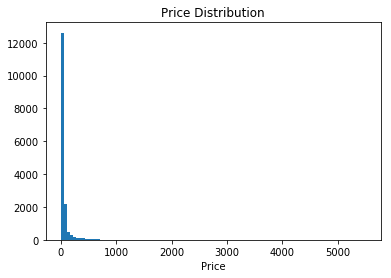

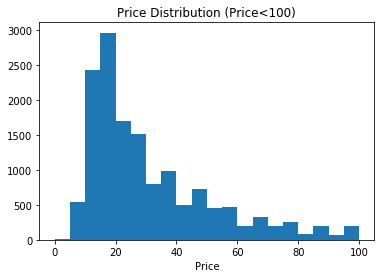

In [133]:
def PriceAnalysis():
    plt.hist(data['minPrice'],100)
    plt.xlabel('Price')
    plt.title('Price Distribution')
    plt.show()
    plt.hist(data[data['minPrice']<100]['minPrice'],20)
    plt.xlabel('Price')
    plt.title('Price Distribution (Price<100)')
    plt.show()
PriceAnalysis()

## 3.2 Varietal Analysis

Varietals with more than 200 wine products:

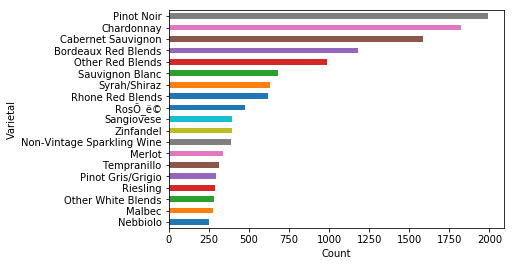

In [192]:
def varietalAnalysis():
    varietal=data.groupby(['Varietal']).size().sort_values(ascending=True)
    varietal[varietal>200].plot(kind="barh")
    plt.title('')
    plt.xlabel('Count')
varietalAnalysis()

Average price for varietals with more than 200 wine products:

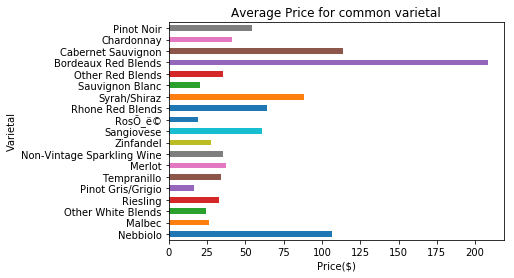

In [193]:
def varietal_price():
    varietal=data.groupby(['Varietal']).size().sort_values(ascending=True)
    df = data.groupby(['Varietal'])['minPrice'].agg(np.mean)
    varietal_price = pd.DataFrame(df)
    varietal_price
    df_new = pd.DataFrame(varietal[varietal>200])
    df_new.merge(varietal_price, left_index=True, right_index=True)['minPrice'].plot(kind="barh")
    plt.title('Average Price for common varietal')
    plt.xlabel('Price($)')
varietal_price()

Number of varietals in different regions:

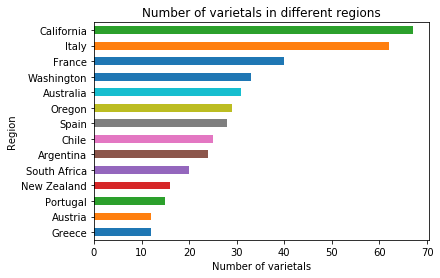

In [195]:
def varietal_region():
    varietal_country=data[['Country','Varietal']].drop_duplicates().groupby(['Country']).size().sort_values(ascending=True)
    varietal_country[varietal_country>10].plot(kind="barh")
    plt.title('Number of varietals in different regions')
    plt.xlabel('Number of varietals')
    plt.ylabel('Region')
varietal_region()

## 3.3 Region Analysis 

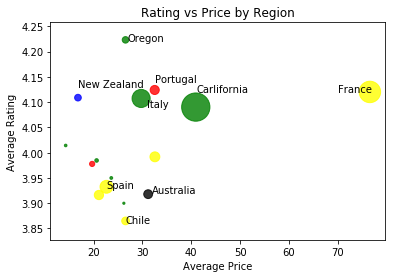

In [137]:
def regionAnalysis():
    wine = data[data["StarRating"]>0]
    count = pd.DataFrame(wine.groupby('Country').agg(['count'])['Title']).reset_index()
    avg_price = pd.DataFrame(wine.groupby('Country')['Price'].agg(['mean'])).reset_index()
    avg_star = pd.DataFrame(wine.groupby('Country')['StarRating'].agg(['mean'])).reset_index()
    count['avg_price'] = avg_price['mean']
    count['avg_star'] = avg_star['mean']
    count_revised =  count.loc[count['count'] >= 5].reset_index()
    col = ['yellow','black','green','yellow','yellow','green',
        'green','green','green','green','blue','green','red','red','yellow','yellow',
        'yellow','yellow','black','yellow','yellow','green','red','blue','green',
        'yellow','yellow']
    plt.title('Rating vs Price by Region')
    plt.xlabel('Average Price')
    plt.ylabel('Average Rating')
    plt.scatter(x = count_revised['avg_price'], y = count_revised['avg_star'], s = count_revised['count'], c = col, alpha = 0.8)
    plt.text(41, 4.12, 'Carlifornia')
    plt.text(70, 4.12, 'France')
    plt.text(31, 4.09, 'Italy' )
    plt.text(22.64, 3.93, 'Spain')
    plt.text(32, 3.92, 'Australia')
    plt.text(32.65,4.14, 'Portugal')
    plt.text(26.54, 3.86, 'Chile')
    plt.text(16.83, 4.13, 'New Zealand')
    plt.text(27, 4.22, 'Oregon')
regionAnalysis()

## 3.4 Year Analysis 

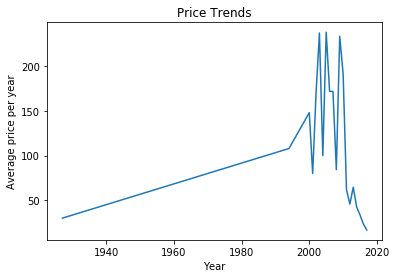

In [138]:
wine = data[data["StarRating"]>0]
year_price = pd.DataFrame(wine.groupby('Year')['Price'].agg(['mean'])).reset_index()
year_price
plt.xlabel('Year')
plt.ylabel('Average price per year')
plt.title('Price Trends')
plt.plot(year_price['Year'], year_price['mean'])

## 3.5 Professional Rating Analysis 

In [139]:
def drop_columns(df, column_names):
    df = df.drop(column_names, axis = 1)
    return df
def get_groupby_counts(df, groups):
    result = df.groupby(groups).count()
    return result

In [140]:
df = drop_columns(data, ['Shopping_Link','Img_src'])
df = df[df["Professional Score"] > 0]

In [141]:
professional_tab = pd.crosstab(df["Professional Score"], df['Country'], margins = True)
professional_tab

Country             Argentina  Australia  Austria  California  Chile  China  \
Professional Score                                                            
1.0                         0          0        0          23      0      0   
9.0                        48         37       10         521     24      0   
10.0                       10          5        0          62      4      0   
88.0                        3          1        0          13      1      0   
89.0                       21         21        1         180     11      0   
90.0                        0          0        0           4      1      0   
91.0                       38         41       10         435     34      0   
92.0                       46         66        7         509     29      0   
93.0                       30         55        2         382     13      1   
94.0                       12         31        1         221      7      0   
95.0                        8         25        2         167      0      0   
96.0                        6          6        2          93      2      0   
97.0                        1          2        0          77      1      0   
98.0                        0          3        0          51      0      0   
99.0                        0          3        0          36      1      0   
100.0                       0          0        0           9      0      0   
All                       223        296       35        2783    128      1   

Country             England  France  Germany  Greece  ...   Other  Other U.S.  \
Professional Score                                    ...                       
1.0                       0       4        1       0  ...       0           0   
9.0                       2     198       12       5  ...       1           1   
10.0                      0      61        1       0  ...       0           0   
88.0                      0       2        0       0  ...       0           0   
89.0                      0      56        1       0  ...       0           0   
90.0                      0       2        0       0  ...       0           0   
91.0                      1     271       10       6  ...       0           1   
92.0                      3     356        7       2  ...       0           0   
93.0                      3     286        5       0  ...       0           0   
94.0                      0     210        1       0  ...       0           0   
95.0                      0     152        4       0  ...       0           0   
96.0                      0     144        0       0  ...       0           0   
97.0                      1      83        1       0  ...       0           0   
98.0                      0      53        0       1  ...       0           0   
99.0                      0      34        0       0  ...       0           0   
100.0                     0      11        0       0  ...       0           0   
All                      10    1923       43      14  ...       1           2   

Country             Portugal  Slovenia  South Africa  Spain  Uruguay  \
Professional Score                                                     
1.0                        0         0             0      1        0   
9.0                       34         1            16     84        0   
10.0                       9         0             1     21        0   
88.0                       2         0             3      5        0   
89.0                       6         0             8     20        0   
90.0                       0         0             0      1        0   
91.0                      29         0             8     66        3   
92.0                      23         0            14     82        1   
93.0                      23         1             3     55        0   
94.0                      14         0             4     21        0   
95.0                      11         0             1      7        0   
96.0                  

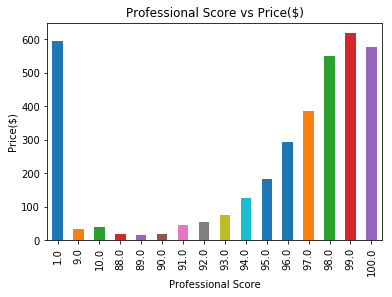

In [142]:
def professionalRating():
    professional_rating_price = data.groupby(['Professional Score']).Price.mean()
    professional_rating_price.plot.bar()
    plt.title('Professional Score vs Price($)')
    plt.ylabel('Price($)')
professionalRating()

## 3.5 Buyers Rating Analysis 

In [143]:
#buyer ratings Crosstab
df = drop_columns(data, ['Shopping_Link','Img_src'])
df = df[df["StarRating"] > 0]
buyer_tab = pd.crosstab(df.StarRating, df.Year, margins = True)
buyer_tab
rating25 = pd.DataFrame(buyer_tab[3:4] + buyer_tab[0:1].values + buyer_tab[1:2].values + buyer_tab[2:3].values, columns = buyer_tab[0:1].columns)
rating25
rating30 = pd.DataFrame(buyer_tab[4:5].values + buyer_tab[5:6].values + buyer_tab[6:7].values + buyer_tab[7:8].values + buyer_tab[8:9], columns = buyer_tab[0:1].columns)
rating30
rating35 = pd.DataFrame(buyer_tab[9:10].values + buyer_tab[10:11].values + buyer_tab[11:12].values + buyer_tab[12:13].values + buyer_tab[13:14], columns = buyer_tab[0:1].columns)
rating35
rating40 = pd.DataFrame(buyer_tab[14:15].values + buyer_tab[15:16].values + buyer_tab[16:17].values + buyer_tab[17:18].values + buyer_tab[18:19], columns = buyer_tab[0:1].columns)
rating40
rating45 = pd.DataFrame(buyer_tab[19:20].values + buyer_tab[20:21].values + buyer_tab[21:22].values + buyer_tab[22:23].values + buyer_tab[23:24], columns = buyer_tab[0:1].columns)
rating45
rating50 = pd.DataFrame(buyer_tab[24:25].values + buyer_tab[25:26].values + buyer_tab[26:27].values + buyer_tab[27:28].values + buyer_tab[28:29], columns = buyer_tab[0:1].columns)
rating50
allogate_crosstab = rating25.append(rating30)
allogate_crosstab = allogate_crosstab.append(rating35)
allogate_crosstab = allogate_crosstab.append(rating40)
allogate_crosstab = allogate_crosstab.append(rating45)
allogate_crosstab = allogate_crosstab.append(rating50)
allogate_crosstab

Year        1927.0  1994.0  2000.0  2001.0  2002.0  2003.0  2004.0  2005.0  \
StarRating                                                                   
2.6              0       0       0       0       0       0       0       0   
3.1              0       0       0       0       0       0       0       1   
3.6              0       0       0       0       0       0       0       0   
4.1              0       0       1       1       1       1       0       2   
4.6              1       0       3       0       0       0       1       6   
All              1       2       4       1       7       3       1      13   

Year        2006.0  2007.0  ...   2009.0  2010.0  2011.0  2012.0  2013.0  \
StarRating                  ...                                            
2.6              0       0  ...        0       1       0       1       0   
3.1              0       0  ...        1       2       1       3       5   
3.6              1       0  ...        2       4       9      10      27   
4.1              1       1  ...        4       3      12      38      77   
4.6              5       2  ...       15      12      22      29      72   
All             11       7  ...       24      30      46      91     205   

Year        2014.0  2015.0  2016.0  2017.0   All  
StarRating                                        
2.6              1       1       2       0     6  
3.1              9       9       4       0    35  
3.6             45      81      62      11   253  
4.1            179     212     195      40   770  
4.6            149     173     154      49   695  
All            437     518     467     130  2005  

[6 rows x 21 columns]

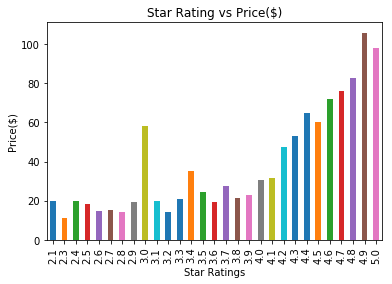

In [144]:
def buyerRating():
    star_rating_price = data.groupby(['StarRating']).Price.mean()
    star_rating_price.plot.bar()
    plt.title('Star Rating vs Price($)')
    plt.xlabel('Star Ratings')
    plt.ylabel('Price($)')
buyerRating()

## 3.6 Popularity Analysis 

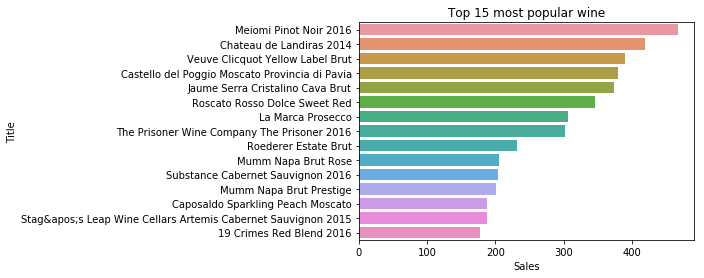

In [145]:
def popularityAnalysis():
    df = data.loc[:,['Title','numRater']]
    new_df = df.sort_values('numRater', ascending=False).head(15)
    sns.barplot(x='numRater', y='Title', data=new_df, orient='h')
    plt.title('Top 15 most popular wine')
    plt.xlabel('Sales')
popularityAnalysis()

# 4. Overview for Users

In [146]:
plot0 = interactive(popularityAnalysis)
plot1 = interactive(varietal_price)
plot2 = interactive(varietal_region)
plot3 = interactive(regionAnalysis)
plot4 = interactive(professionalRating)
plot5 = interactive(buyerRating)

In [147]:
children = [plot0,plot1, plot2, plot3, plot4,plot5]
tab = widgets.Tab()
tab.children = children
tab.set_title(0, 'Popular Wine')
tab.set_title(1, 'Varietal vs Price')
tab.set_title(2, 'Varietal vs Region')
tab.set_title(3, 'Region Overview')
tab.set_title(4, 'Professional Ratings Overview')
tab.set_title(5, 'Buyers Ratings Overview')
tab

Tab(children=(interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',)), interactive(children=(Output(),), _dom_classes=('widget-interact',))), _titles={'0': 'Popular Wine', '1': 'Varietal vs Price', '2': 'Varietal vs Region', '3': 'Region Overview', '4': 'Professional Ratings Overview', '5': 'Buyers Ratings Overview'})

# 5. Recommendation System

## --Recommend Products based on Users' prefernces

## 5.1 Search by Title 

In [154]:
Search = widgets.Text(
    value= None,
    placeholder='Type something',
    description='Search:',
    disabled=False
)
Search

Text(value='', description='Search:', placeholder='Type something')

In [158]:
product_idx = {}
booleanVal_product=[None] * len(data)
for i in range(0, len(data)):
    ratio = fuzz.ratio(Search.value, data.ix[i,'Title'])
    partial_ratio = fuzz.partial_ratio(Search.value, data.ix[i,'Title'])
    token_ratio = fuzz.token_sort_ratio(Search.value,data.ix[i,'Title'])
    if ratio == 100: 
        print(str(i) + ' ' +data.ix[i,'Title'])
        product_idx[i] = ratio
        booleanVal_product[i] = True
    else:
        if partial_ratio >= 90:
            print(str(i) + ' ' +data.ix[i,'Title'])
            product_idx[i] = partial_ratio
            booleanVal_product[i] = True
        elif token_ratio >= 90:
            print(str(i) + ' ' +data.ix[i,'Title'])
            product_idx[i] = token_ratio
            booleanVal_product[i] = True
        else:
            booleanVal_product[i] = False

/Users/r./anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/Users/r./anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/r./anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/r./anaconda3/lib/python3.6/site-packages/ipyker

3 Rombauer Chardonnay 2017
382 Rombauer Chardonnay (375ML half-bottle) 2017
772 Rombauer Chardonnay (1.5 Liter Magnum) 2017
1296 90+ Point Rombauer Chardonnay & California Wine Tote
7386 Rombauer Chardonnay (3 Liter Bottle) 2017


In [161]:
df = data
df = df.loc[booleanVal_product,:]
df_product = pd.DataFrame(product_idx, index=['score']).T.sort_values(by='score',ascending=False)

In [162]:
index = list(df_product.index)
df_display = data.ix[index,['Title', 'minPrice', 'Professional Score', 'StarRating','numRater','Shopping_Link']]
df_display

/Users/r./anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/Users/r./anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Title  minPrice  \
3                              Rombauer Chardonnay 2017     36.99   
382        Rombauer Chardonnay (375ML half-bottle) 2017     19.99   
772         Rombauer Chardonnay (1.5 Liter Magnum) 2017     81.97   
1296  90+ Point Rombauer Chardonnay & California Win...     52.99   
7386          Rombauer Chardonnay (3 Liter Bottle) 2017    199.97   

      Professional Score  StarRating  numRater  \
3                    NaN         4.9         9   
382                  NaN         0.0         0   
772                  NaN         0.0         0   
1296                 NaN         0.0         0   
7386                 NaN         0.0         0   

                                          Shopping_Link  
3     https://www.wine.com/product/Rombauer-Chardonn...  
382   https://www.wine.com/product/Rombauer-Chardonn...  
772   https://www.wine.com/product/Rombauer-Chardonn...  
1296  https://www.wine.com/product/90-Point-Rombauer...  
7386  https://www.wine.com/product/Rombauer-Chardonn...

## 5.2 Search by Varietal 

In [166]:
selectVarietal = widgets.Dropdown(
    options=list(tasteData.iloc[:,0].unique()),
    value = None,
    description='Varietal:'
)
selectVarietal

Dropdown(description='Varietal:', options=('Falanghina', 'Negroamaro', 'Montepulciano', 'Grillo', 'Vermouth', …

In [168]:
#Display Introduction
try:
    #varietal_intro[varietal_filename]
    varietal_filename = selectVarietal.value+".txt"
    print(varietal_intro[varietal_filename])
except:
    print("No Results Matched")


No Results Matched


In [169]:
df = data
if selectVarietal.value: 
    boolVal_varietal = (df['Varietal'] == selectVarietal.value)
else:
    boolVal_varietal = (df['Varietal'] != 0)
    print("No result")
df.loc[boolVal_varietal,:]
#boolVal_varietal

No result


Title    Year  \
0             Caymus Napa Valley Cabernet Sauvignon 2016  2016.0   
1                        Dom Perignon with Gift Box 2009  2009.0   
2                                         Ornellaia 2015  2015.0   
3                               Rombauer Chardonnay 2017  2017.0   
4      Domaine de la Janasse Chateauneuf-du-Pape Cuve...  2016.0   
5         Silver Oak Napa Valley Cabernet Sauvignon 2013  2013.0   
6             Duckhorn Vineyards 90+ Point Wine Gift Set     NaN   
7      Tour Saint Christophe Les Terrasses de Saint C...  2014.0   
8                        Tua Rita Redigaffi Toscana 2015  2015.0   
9           Duckhorn Napa Valley Cabernet Sauvignon 2015  2015.0   
10                Joseph Phelps Insignia 2014 6 Pack OWC  2014.0   
11                                   Dominus Estate 2015  2015.0   
12               Scattered Peaks Cabernet Sauvignon 2015  2015.0   
13     Silver Oak Alexander Valley Cabernet Sauvignon...  2014.0   
14          Chappellet Signature Cabernet Sauvignon 2015  2015.0   
15                      Veuve Clicquot Yellow Label Brut     NaN   
16             La Rioja Alta Gran Reserva 904 Tinto 2009  2009.0   
17                              Antinori Tignanello 2015  2015.0   
18     Kathryn Hall Cabernet Sauvignon 6-Pack + BONUS...     NaN   
19     Hall Eighteen Seventy-Three Cabernet Sauvignon...  2014.0   
20     Robert Mondavi To Kalon Vineyard Reserve Caber...  2014.0   
21                                        Quintessa 2015  2015.0   
22      Caymus Special Selection Cabernet Sauvignon 2014  2014.0   
23     Chateau Ste. Michelle Cold Creek Vineyard Cabe...  2013.0   
24                  Silver Oak Trophy Reds Wine Gift Set     NaN   
25                           90+ Point Red Wine Gift Set     NaN   
26     Quinta do Crasto Douro Red Reserva Old Vines 2015  2015.0   
27     Raymond Reserve Selection Cabernet Sauvignon 2015  2015.0   
28                       Tenuta San Guido Sassicaia 2015  2015.0   
29                   Austin Hope Cabernet Sauvignon 2015  2015.0   
...                                                  ...     ...   
16295                         Kettmeir Pinot Grigio 2017  2017.0   
16296                    Olga Raffault Les Picasses 2013  2013.0   
16297     Santa Margherita Chianti Classico Riserva 2014  2014.0   
16298                       Kettmeir Muller Thurgau 2017  2017.0   
16299        St. Clair Vinos de los Muertos Blanco Dulce     NaN   
16300     Lamole di Lamole Chianti Classico Riserva 2014  2014.0   
16301         Feudo Zirtari Nero d&apos;Avola/Syrah 2015  2015.0   
16302                        Sassoregale Sangiovese 2016  2016.0   
16303  Concha y Toro Casillero Del Diablo Cabernet Sa...  2017.0   
16304  Gaja Pieve Santa Restituta Brunello di Montalc...  2013.0   
16305  Promise Rutherford Cabernet Sauvignon (Premier...  2009.0   
16306              Karthauserhof Riesling QbA Ruwer 2016  2016.0   
16307                         Kettmeir Pinot Bianco 2017  2017.0   
16308  Marc Kreydenweiss CostiÃ­Ãres-de-NÃ­Â¬mes Per...  2006.0   
16309  Antinori Villa Antinori Chianti Classico Riser...  2012.0   
16310    White Nike Wine.com Hat (FREE ground shipping!)     NaN   
16311           Antinori Guado al Tasso Il Bruciato 2015  2015.0   
16312       Mas Janeil Cotes du Roussillon Villages 2012  2012.0   
16313                  Chalk Hill Estate Pinot Noir 2014  2014.0   
16314  Ruffino Ducale Chianti Classico Riserva (375ML...  2012.0   
16315  Clos Du Val A Cappella Cabernet Sauvignon (Pre...  2011.0   
16316                                Verite La Muse 2013  2013.0   
16317  ONEHOPE Elway&apos;s Reserve Cabernet Sauvigno...  2013.0   
16318                  Guigal La Mouline Cote Rotie 2012  2012.0   
16319                   Guigal La Turque Cote Rotie 2012  2012.0   
16320  Andrew Rich Age of Majority Pinot Noir (Willam...  2015.0   
16321                            Mouton Cadet Blanc 2014  2014.0   
16322  Mount Veeder Winery Estate Caber

## 5.3 Search by Price Range 

In [170]:
selectPrice = widgets.FloatRangeSlider(
    value=None,
    min=0,
    max=5500.0,
    step=0.1,
    description='Price Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
selectPrice

FloatRangeSlider(value=(1375.0, 4125.0), continuous_update=False, description='Price Range:', max=5500.0)

In [171]:
selectPrice.value
minPrice = selectPrice.value[0]
maxPrice = selectPrice.value[1]
df = data

boolVal_price = (df['Price']>=minPrice) & (df['Price']<=maxPrice)
df.loc[boolVal_price,:]

Title    Year  \
50                                  Chateau Margaux 2015  2015.0   
205    Chateau Lafite Rothschild (1.5 Liter Magnum) 2015  2015.0   
6612                           Chateau Cheval Blanc 1943  1943.0   
6814                                 Chateau Petrus 2014  2014.0   
7213   Fontodi Flaccianello della Pieve (6 Liter Bott...  2010.0   
7569                      Chateau Lafite Rothschild 1996  1996.0   
7878              Chateau Petrus (Futures Pre-Sale) 2017  2017.0   
7999                                 Chateau Petrus 1987  1987.0   
8882                                 Chateau Petrus 2003  2003.0   
10245                                Chateau Petrus 1993  1993.0   
11628  Oakville Winegrowers Association Oakville Cuve...  2013.0   
12292                Chateau Pavie (6 Liter Bottle) 2003  2003.0   
12666                                Chateau Petrus 1996  1996.0   
12718            Screaming Eagle Cabernet Sauvignon 2011  2011.0   
13060                                Chateau Petrus 1999  1999.0   
13276                                Chateau Petrus 1995  1995.0   
13527                    Ornellaia (6 Liter Bottle) 2015  2015.0   
13942                Vietti Barolo Ravera (5 Liter) 2014  2014.0   
14007  Casanova di Neri Brunello di Montalcino Cerret...  2012.0   
14684  Chateau Lafite Rothschild (1.5 Liter Magnum Fu...  2016.0   
14734                    Masseto (1.5 Liter Magnum) 2014  2014.0   
15054              Harlan Estate (1.5 Liter Magnum) 2014  2014.0   
15245  Sine Qua Non Rattrapante Grenache (1.5L Magnum...  2012.0   
15360                               Chateau Lafleur 2010  2010.0   
15374      Chateau Troplong Mondot (3 Liter Bottle) 2005  2005.0   
15588             Chateau Montrose (3 Liter Bottle) 2003  2003.0   
15629             Chateau Latour (1.5 Liter Magnum) 2000  2000.0   
15691    Chateau Leoville Poyferre (6 Liter Bottle) 2009  2009.0   
15899  Chateau Cheval Blanc (1.5 Liter Magnum Futures...  2016.0   
15985            Screaming Eagle Cabernet Sauvignon 2013  2013.0   
16042    Scarecrow Cabernet Sauvignon (1.5L Magnum) 2014  2014.0   
16060    Scarecrow Cabernet Sauvignon (1.5L Magnum) 2012  2012.0   
16067    Scarecrow Cabernet Sauvignon (1.5L Magnum) 2013  2013.0   

                  Varietal    Price         Region     Country  Score_WS  \
50     Bordeaux Red Blends  1699.97       Bordeaux      France      99.0   
205    Bordeaux Red Blends  1499.97       Bordeaux      France       NaN   
6612   Bordeaux Red Blends  3999.97       Bordeaux      France       NaN   
6814   Bordeaux Red Blends  2399.99       Bordeaux      France      95.0   
7213            Sangiovese  1499.98        Tuscany       Italy       NaN   
7569   Bordeaux Red Blends  1599.97       Bordeaux      France      96.0   
7878   Bordeaux Red Blends  2699.97       Bordeaux      France       NaN   
7999   Bordeaux Red Blends  2499.97       Bordeaux      France       NaN   
8882   Bordeaux Red Blends  2999.97       Bordeaux      France      98.0   
10245  Bordeaux Red Blends  2399.97       Bordeaux      France      95.0   
11628   Cabernet Sauvignon  1799.97    Napa Valley  California       NaN   
12292  Bordeaux Red Blends  2499.98       Bordeaux      France      97.0   
12666  Bordeaux Red Blends  2799.97       Bordeaux      France      94.0   
12718   Cabernet Sauvignon  2899.97    Napa Valley  California       NaN   
13060  Bordeaux Red Blends  2499.97       Bordeaux      France       NaN   
13276  Bordeaux Red Blends  2999.97       Bordeaux      France      97.0   
13527  Bordeaux Red Blends  2699.97        Tuscany       Italy      97.0   
13942             Nebbiolo  2069.97       Piedmont       Italy       NaN   
14007           Sangiovese  3059.00        Tuscany       Italy      98.0   
14684  Bordeaux Red Blends  1499.97       Bordeaux      France       NaN   
14734               Merlot  1469.97        Tuscany       Italy      94.0   
15054  Bordeaux Red Blends  2299.97    Napa Valley  California    

## 5.4 Search by Region 

In [172]:
selectRegion = widgets.Dropdown(
    options= list(data['Country'].unique()),
    value = None,
    description='Region:'
)
selectRegion

Dropdown(description='Region:', options=('California', 'France', 'Italy', 'Spain', 'Washington', 'Other', 'Por…

In [175]:
if selectRegion.value:
    boolVal_region = (df['Country'] == selectRegion.value)
    print(df.loc[boolVal_region,:])
else:
    boolVal_region = (df['Country'] != 0)
    print("No results matched")

                                                   Title    Year  \
1                        Dom Perignon with Gift Box 2009  2009.0   
4      Domaine de la Janasse Chateauneuf-du-Pape Cuve...  2016.0   
7      Tour Saint Christophe Les Terrasses de Saint C...  2014.0   
15                      Veuve Clicquot Yellow Label Brut     NaN   
31                      Louis Roederer Cristal Brut 2008  2008.0   
35                      Veuve Clicquot Vintage Brut 2008  2008.0   
38                             Laurent-Perrier Brut Rose     NaN   
40                                Chateau Sansonnet 2015  2015.0   
42     Domaine du Vieux Telegraphe Chateauneuf-du-Pap...  2016.0   
45                              Chateau Clos du Roy 2015  2015.0   
46                       Chateau Leoville Las Cases 2005  2005.0   
49            Veuve Clicquot & Champagne Ice Bucket Gift     NaN   
50                                  Chateau Margaux 2015  2015.0   
54                             Chateau Cheval Bl

## 5.5 Search by Year 

In [176]:
selectYear = widgets.IntRangeSlider(
    value=[1927, 2018],
    min=1927,
    max=2018,
    step=1,
    description='Year Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
selectYear

IntRangeSlider(value=(1927, 2018), continuous_update=False, description='Year Range:', max=2018, min=1927)

In [177]:
df = data
minYear = selectYear.value[0]
maxYear = selectYear.value[1]
boolVal_yr = (df['Year'] >= minYear) & (df['Year'] <= maxYear)
boolVal_yr
df.loc[boolVal_yr,:]

Title    Year  \
0             Caymus Napa Valley Cabernet Sauvignon 2016  2016.0   
1                        Dom Perignon with Gift Box 2009  2009.0   
2                                         Ornellaia 2015  2015.0   
3                               Rombauer Chardonnay 2017  2017.0   
4      Domaine de la Janasse Chateauneuf-du-Pape Cuve...  2016.0   
5         Silver Oak Napa Valley Cabernet Sauvignon 2013  2013.0   
7      Tour Saint Christophe Les Terrasses de Saint C...  2014.0   
8                        Tua Rita Redigaffi Toscana 2015  2015.0   
9           Duckhorn Napa Valley Cabernet Sauvignon 2015  2015.0   
10                Joseph Phelps Insignia 2014 6 Pack OWC  2014.0   
11                                   Dominus Estate 2015  2015.0   
12               Scattered Peaks Cabernet Sauvignon 2015  2015.0   
13     Silver Oak Alexander Valley Cabernet Sauvignon...  2014.0   
14          Chappellet Signature Cabernet Sauvignon 2015  2015.0   
16             La Rioja Alta Gran Reserva 904 Tinto 2009  2009.0   
17                              Antinori Tignanello 2015  2015.0   
19     Hall Eighteen Seventy-Three Cabernet Sauvignon...  2014.0   
20     Robert Mondavi To Kalon Vineyard Reserve Caber...  2014.0   
21                                        Quintessa 2015  2015.0   
22      Caymus Special Selection Cabernet Sauvignon 2014  2014.0   
23     Chateau Ste. Michelle Cold Creek Vineyard Cabe...  2013.0   
26     Quinta do Crasto Douro Red Reserva Old Vines 2015  2015.0   
27     Raymond Reserve Selection Cabernet Sauvignon 2015  2015.0   
28                       Tenuta San Guido Sassicaia 2015  2015.0   
29                   Austin Hope Cabernet Sauvignon 2015  2015.0   
30                           Joseph Phelps Insignia 2015  2015.0   
31                      Louis Roederer Cristal Brut 2008  2008.0   
32                     Substance Cabernet Sauvignon 2016  2016.0   
33        Frank Family Vineyards Cabernet Sauvignon 2015  2015.0   
34             Hall Kathryn Hall Cabernet Sauvignon 2015  2015.0   
...                                                  ...     ...   
16293  Jean-Paul Brun Domaine des Terres Dorees Cote-...  2016.0   
16294             Lamole di Lamole Chianti Classico 2015  2015.0   
16295                         Kettmeir Pinot Grigio 2017  2017.0   
16296                    Olga Raffault Les Picasses 2013  2013.0   
16297     Santa Margherita Chianti Classico Riserva 2014  2014.0   
16298                       Kettmeir Muller Thurgau 2017  2017.0   
16300     Lamole di Lamole Chianti Classico Riserva 2014  2014.0   
16301         Feudo Zirtari Nero d&apos;Avola/Syrah 2015  2015.0   
16302                        Sassoregale Sangiovese 2016  2016.0   
16303  Concha y Toro Casillero Del Diablo Cabernet Sa...  2017.0   
16304  Gaja Pieve Santa Restituta Brunello di Montalc...  2013.0   
16305  Promise Rutherford Cabernet Sauvignon (Premier...  2009.0   
16306              Karthauserhof Riesling QbA Ruwer 2016  2016.0   
16307                         Kettmeir Pinot Bianco 2017  2017.0   
16308  Marc Kreydenweiss CostiÃ­Ãres-de-NÃ­Â¬mes Per...  2006.0   
16309  Antinori Villa Antinori Chianti Classico Riser...  2012.0   
16311           Antinori Guado al Tasso Il Bruciato 2015  2015.0   
16312       Mas Janeil Cotes du Roussillon Villages 2012  2012.0   
16313                  Chalk Hill Estate Pinot Noir 2014  2014.0   
16314  Ruffino Ducale Chianti Classico Riserva (375ML...  2012.0   
16315  Clos Du Val A Cappella Cabernet Sauvignon (Pre...  2011.0   
16316                                Verite La Muse 2013  2013.0   
16317  ONEHOPE Elway&apos;s Reserve Cabernet Sauvigno...  2013.0   
16318                  Guigal La Mouline Cote Rotie 2012  2012.0   
16319                   Guigal La Turque Cote Rotie 2012  2012.0   
16320  Andrew Rich Age of Majority Pinot Noir (Willam...  2015.0   
16321                            Mouton Cadet Blanc 2014  2014.0   
16322  Mount Veeder Winery Estate Caber

## 5.6 Search by Taste 

Users can select mutiple tastes, all the products with selected tastes will be showed.

In [216]:
Tastes=['all']
for taste in list(tasteData.iloc[:,1].unique()):
    for s in taste.split(','):
        Tastes.append(s.strip())
Tastes=list(set(Tastes))
Tastes.sort()
Tastes[0]

'all'

In [217]:
selectTaste = widgets.SelectMultiple(
    options= Tastes,
    value=['all'],
    rows=10,
    description='Taste:',
    disabled=False
)
selectTaste

SelectMultiple(description='Taste:', index=(0,), options=('all', 'almond', 'berry', 'blossom', 'chocolatey', '…

In [208]:
boolVal_taste = pd.notnull(data_merged['Title'])
if 'all' not in selectTaste.value:
    for index in data.index:
        t=data.loc[index]['Taste']
        if pd.isnull(t):
            boolVal_taste[index]=False
        else:
            b=True
            for taste in selectTaste.value:
                b=b&(taste in t)
            if not b:
                b=True
                for taste in t.split(','):
                    b=b&(taste.strip() in selectTaste.value)
                    boolVal_taste[index]=b
    if not boolVal_taste.any():
        print("No results matched")

data.loc[boolVal_taste,:]

Title    Year  \
47               Dog Point Vineyard Sauvignon Blanc 2017  2017.0   
103     Henri Bourgeois Sancerre Les Baronnes Blanc 2017  2017.0   
105                The White Knight Sauvignon Blanc 2014  2014.0   
145                       Cakebread Sauvignon Blanc 2017  2017.0   
152    Craggy Range Te Muna Road Vineyard Sauvignon B...  2017.0   
189                        Duckhorn Sauvignon Blanc 2017  2017.0   
200                      Cloudy Bay Sauvignon Blanc 2017  2017.0   
221                                   Catena Malbec 2015  2015.0   
244                        Dona Paula Estate Malbec 2016  2016.0   
268                      Red Schooner by Caymus Voyage 5     NaN   
286                        Rombauer Sauvignon Blanc 2017  2017.0   
288                        Greywacke Wild Sauvignon 2015  2015.0   
296                              Catena Alta Malbec 2014  2014.0   
309                        Nautilus Sauvignon Blanc 2017  2017.0   
414                      Whitehaven Sauvignon Blanc 2017  2017.0   
418    Henri Bourgeois Sancerre La Cote des Monts Dam...  2016.0   
427                           Norton Malbec Reserva 2014  2014.0   
431              Astrolabe Province Sauvignon Blanc 2017  2017.0   
443                    Wither Hills Sauvignon Blanc 2017  2017.0   
447                           Mohua Sauvignon Blanc 2017  2017.0   
453                        Vavasour Sauvignon Blanc 2016  2016.0   
463    Frog&apos;s Leap Napa Valley Sauvignon Blanc 2017  2017.0   
479                                    Tilia Malbec 2017  2017.0   
500                    Lail Georgia Sauvignon Blanc 2016  2016.0   
553          Domaine Yves Martin Chavignol Sancerre 2017  2017.0   
558                    Kim Crawford Sauvignon Blanc 2017  2017.0   
564                     Spottswoode Sauvignon Blanc 2017  2017.0   
566                     Tiki Estate Sauvignon Blanc 2016  2016.0   
572                            Norton D.O.C. Malbec 2015  2015.0   
573                      Chalk Hill Sauvignon Blanc 2016  2016.0   
...                                                  ...     ...   
14838                     Ruca Malen Yauquen Malbec 2016  2016.0   
14981                  Clos du Bois Sauvignon Blanc 2015  2015.0   
15024                      Alta Vista Estate Malbec 2015  2015.0   
15127                  Baron Herzog Sauvignon Blanc 2016  2016.0   
15155           Kunde Magnolia Lane Sauvignon Blanc 2016  2016.0   
15224          TintoNegro Uco Valley-Mendoza Malbec 2016  2016.0   
15230                Bodegas Renacer Renacer Malbec 2013  2013.0   
15240          Provenance Vineyards Sauvignon Blanc 2017  2017.0   
15247                        Indaba Sauvignon Blanc 2017  2017.0   
15302        Finca Decero Remolinos Vineyard Malbec 2016  2016.0   
15407                   St. Francis Sauvignon Blanc 2016  2016.0   
15657  Vina Cobos Bramare Marchiori Vineyard Malbec 2014  2014.0   
15686                    13 Celsius Sauvignon Blanc 2016  2016.0   
15726      William Hill Napa Valley Sauvignon Blanc 2016  2016.0   
15737                   San Michele Sauvignon Blanc 2015  2015.0   
15898          Terrazas de los Andes Reserva Malbec 2016  2016.0   
15926                     Heritance Sauvignon Blanc 2015  2015.0   
15952         Dona Paula Malbec Seleccion de Bodega 2014  2014.0   
16049                    Gouguenheim Reserva Malbec 2015  2015.0   
16095                    Los Vascos Sauvignon Blanc 2017  2017.0   
16161         Domaine Saint Roch Touraine Sauvignon 2016  2016.0   
16168                                Argento Malbec 2015  2015.0   
16210                    Slow Press Sauvignon Blanc 2016  2016.0   
16222               Riebeek Cellars Sauvignon Blanc 2016  2016.0   
16227                   Graffigna Centenario Malbec 2016  2016.0   
16233             Amici Napa Valley Sauvignon Blanc 2013  2013.0   
16248                                  Maipe Malbec 2017  2017.0   
16249                                  

## 5.7 Search by Varietal, Year, Taste and Region

In [181]:
boolVal_yr
boolVal_price
boolVal_varietal
boolVal_region
boolVal_taste

boolVal = []
for i in range(0, len(data)):
    boolVal.append(all([boolVal_yr[i], boolVal_price[i],boolVal_varietal[i],boolVal_region[i],boolVal_taste[i]]))
df = data_merged   
boolVal
if len(data.loc[boolVal,:])>0: data.loc[boolVal,:]
else: print("No Results Matched")
       

No Results Matched


## 5.8 Compare Prices 

Given the product title in the wine catalog, search in the data_compare dataframe, show all available prices in different online stores:

In [182]:
def compare_price(search_title):
    i=data[data['Title']==search_title].index[0]
    price_list=data[data['Title']==search_title][['Title','Price','Shopping_Link']]
    price_list['Website']='Wine.com'
    price_list2=data_compare[data_compare['Title']==search_title][['Website','Title2','Price','Shopping_Link']].rename(columns={'Title2':'Title'})
    price_list=price_list2.append(price_list,sort='Price')
    print('The lowest price is $',price_list.iloc[0]['Price'],'on',price_list.iloc[0]['Website'])
    return price_list[['Website','Title','Price','Shopping_Link']]
compare_price('Ruffino Prosecco')

The lowest price is $ 9.47 on Total Wine


Website                                      Title  Price  \
150   Total Wine                           Ruffino Prosecco   9.47   
151   Total Wine                           Ruffino Prosecco  10.99   
622       Amazon  Ruffino Prosecco DOC Sparkling White Wine  11.97   
1284    Wine.com                           Ruffino Prosecco  11.99   

                                          Shopping_Link  
150   https://www.totalwine.com/wine/champagne-spark...  
151   https://www.totalwine.com/wine/champagne-spark...  
622                https://www.amazon.com/dp/B005J0PWG8  
1284  https://www.wine.com/product/Ruffino-Prosecco/...

# 6. Recommend Similar Items

Given a product in the wine catalog, calculate the similarity score based on different dimensions - title, year, price, varietal, taste and region, show the top 20 products with the highest score.

In [201]:
def find_similar_items(search_title):
    i=data[data['Title']==search_title].index[0]
    similar_list=pd.DataFrame(columns=['Title','Score'])
    for index in data.index:
        if index!=i:
            score=0
            r1=fuzz.token_sort_ratio(data.loc[index]['Title'], search_title)
            r2=fuzz.token_set_ratio(data.loc[index]['Title'], search_title)                        
            if max(r1,r2)>=80:
                score+=max(r1,r2)
            score+=max(0,10-abs(data.loc[index]['Year']-data.loc[i]['Year']))*3
            score+=min(data.loc[index]['Price'],data.loc[i]['Price'])/max(data.loc[index]['Price'],data.loc[i]['Price'])*30
            if data.loc[index]['Varietal']==data.loc[i]['Year']:
                score+=50
            else:
                r1=fuzz.token_sort_ratio(data.loc[index]['Taste'], data.loc[i]['Taste'])
                r2=fuzz.token_set_ratio(data.loc[index]['Taste'], data.loc[i]['Taste'])
                score+=max(r1,r2)/2
            if data.loc[index]['Country']==data.loc[i]['Country']:
                score+=40   
            if data.loc[index]['Region']==data.loc[i]['Region']:
                score+=30  
            similar_list=similar_list.append({'Title': data.loc[index]['Title'],'Score': score},ignore_index=True)
    similar_items=similar_list.sort_values(by='Score',ascending=False).iloc[:20,:1].merge(data,on='Title')                      
    return similar_items
#find_similar_items('Rombauer Chardonnay 2017')
find_similar_items(df_display.iloc[0,:]['Title'])

Title    Year    Varietal  \
0        Rombauer Chardonnay (375ML half-bottle) 2017  2017.0  Chardonnay   
1         Rombauer Chardonnay (1.5 Liter Magnum) 2017  2017.0  Chardonnay   
2                               Lloyd Chardonnay 2017  2017.0  Chardonnay   
3           Rombauer Chardonnay (3 Liter Bottle) 2017  2017.0  Chardonnay   
4                              Oberon Chardonnay 2016  2016.0  Chardonnay   
5                               Quilt Chardonnay 2017  2017.0  Chardonnay   
6                              AERENA Chardonnay 2017  2017.0  Chardonnay   
7                                Camp Chardonnay 2017  2017.0  Chardonnay   
8                             Materra Chardonnay 2016  2016.0  Chardonnay   
9                                Simi Chardonnay 2017  2017.0  Chardonnay   
10                            Raeburn Chardonnay 2016  2016.0  Chardonnay   
11  Barnett Vineyards Sangiacomo Vineyard Chardonn...  2017.0  Chardonnay   
12   Judd&apos;s Hill Stainless Steel Chardonnay 2016  2016.0  Chardonnay   
13                               Merf Chardonnay 2017  2017.0  Chardonnay   
14                    Scribe Carneros Chardonnay 2015  2015.0  Chardonnay   
15                 Merryvale Carneros Chardonnay 2016  2016.0  Chardonnay   
16                              Milou Chardonnay 2017  2017.0  Chardonnay   
17  Barnett Vineyards Sangiacomo Vineyard Chardonn...  2015.0  Chardonnay   
18                 Silverado Carneros Chardonnay 2016  2016.0  Chardonnay   
19                   William Harrison Chardonnay 2015  2015.0  Chardonnay   

     Price                Region     Country  Score_WS  Score_RP  Score_W&S  \
0    19.99              Carneros  California       NaN       NaN        NaN   
1    81.97              Carneros  California       NaN       NaN        NaN   
2    38.99              Carneros  California       NaN       NaN        NaN   
3   199.97              Carneros  California       NaN       NaN        NaN   
4    22.99              Carneros  California      90.0       NaN        NaN   
5    33.99           Napa Valley  California       NaN       NaN        NaN   
6    23.99         Sonoma County  California       NaN       NaN        NaN   
7    17.99         Sonoma County  California       NaN       NaN        NaN   
8    26.99           Napa Valley  California       NaN       NaN        NaN   
9    14.99         Sonoma County  California       NaN       NaN        NaN   
10   16.99         Sonoma County  California       NaN       NaN        NaN   
11   35.99              Carneros  California       NaN       NaN        NaN   
12   35.99              Carneros  California       NaN       NaN        NaN   
13   11.99       Columbia Valley  Washington       NaN       NaN        NaN   
14   36.99              Carneros  California       NaN       NaN        NaN   
15   32.99              Carneros  California      91.0      90.0        NaN   
16   12.99  Languedoc-Roussillon      France       NaN       NaN        NaN   
17   35.99              Carneros  California       NaN       NaN        NaN   
18   31.99              Carneros  California       NaN       NaN        NaN   
19   34.99              Carneros  California       NaN       NaN        NaN   

    Score_JH           ...             Score_JD  Professional Score  \
0        NaN           ...                  NaN                91.0   
1        NaN           ...                  NaN                91.0   
2        NaN           ...                  NaN                 NaN   
3        NaN           ...                  NaN                91.0   
4        NaN           ...                  NaN                 9.0   
5        NaN           ...                  NaN                 NaN   
6        NaN           ...                  NaN                 NaN   
7        NaN           ...                  NaN                 NaN   
8        NaN           ...                  NaN                 9.0   
9        NaN           ...                  NaN             